In [84]:
import numpy as np
import pandas as pd
import nest_asyncio
nest_asyncio.apply()
import stan
import matplotlib.pyplot as plt
import arviz as az
import random
import openpyxl
import seaborn

## tutorial

In [2]:
schools_code = """
data {
  int<lower=0> J;         // number of schools
  real y[J];              // estimated treatment effects
  real<lower=0> sigma[J]; // standard error of effect estimates
}
parameters {
  real mu;                // population treatment effect
  real<lower=0> tau;      // standard deviation in treatment effects
  vector[J] eta;          // unscaled deviation from mu by school
}
transformed parameters {
  vector[J] theta = mu + tau * eta;        // school treatment effects
}
model {
  target += normal_lpdf(eta | 0, 1);       // prior log-density
  target += normal_lpdf(y | theta, sigma); // log-likelihood
}
"""

schools_data = {"J": 8,
                "y": [28,  8, -3,  7, -1,  1, 18, 12],
                "sigma": [15, 10, 16, 11,  9, 11, 10, 18]}

posterior = stan.build(schools_code, data=schools_data)
fit = posterior.sample(num_chains=4, num_samples=1000)
# eta = fit["eta"]  # array with shape (8, 4000)
# df = fit.to_frame()  # pandas `DataFrame, requires pandas

Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 6.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!


## 베르누이 간단한 튜토리얼

In [29]:
bn_code = """

data {
    int N;
    int <lower = 0, upper = 1> y[N];
}

parameters {
     real <lower = 0, upper = 1> p;
}

model {
    for (n in 1:N)
     y[n] ~ bernoulli(p);
     
    p ~ beta(1,1);
}

"""

In [30]:
temp_data = {
    'N' : 10,
    'y' : [1, 1, 0, 0, 1, 0, 1, 1, 1, 1] 
}
    

In [31]:
posterior = stan.build(bn_code, data=temp_data, random_seed = 123)
fit = posterior.sample(num_chains = 4, num_samples=2000, num_warmup=1000)
trial1 = fit.to_frame()
trial1

Building: found in cache, done.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!


parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,p
draws,,,,,,,,
0,-7.785915,1.000000,0.837619,2.0,7.0,0.0,8.595957,0.737497
1,-7.938903,0.947149,1.267729,1.0,1.0,0.0,7.946203,0.765484
2,-7.773780,0.533022,1.283767,1.0,3.0,0.0,9.134156,0.734666
3,-7.638794,0.994361,0.981196,2.0,3.0,0.0,7.682067,0.661849
4,-8.563015,0.922366,0.837619,2.0,7.0,0.0,8.668317,0.828881
...,...,...,...,...,...,...,...,...
7995,-8.149111,0.902718,0.981196,2.0,3.0,0.0,8.309398,0.792294
7996,-7.963854,0.869000,0.837619,1.0,3.0,0.0,9.016855,0.769172
7997,-8.492514,0.774814,1.267729,1.0,3.0,0.0,8.833733,0.823596


In [32]:
trial1['p'].describe()

count    8000.000000
mean        0.667559
std         0.133379
min         0.183397
25%         0.575840
50%         0.678283
75%         0.768627
max         0.970558
Name: p, dtype: float64

array([[<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

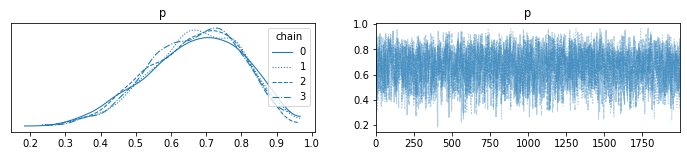

In [6]:
az.plot_trace(fit, legend=True, kind='trace')


array([<AxesSubplot:title={'center':'p'}>], dtype=object)

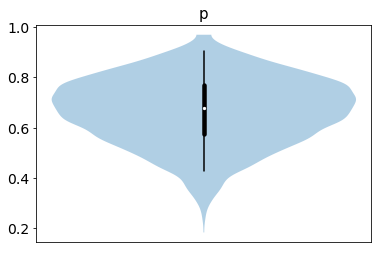

In [7]:
az.plot_violin(fit)

array([[<AxesSubplot:title={'center':'p'}>]], dtype=object)

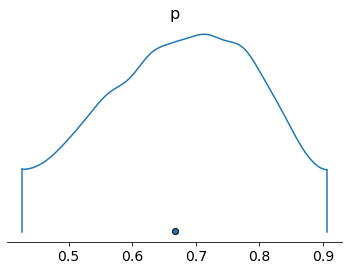

In [8]:
az.plot_density(fit)

<AxesSubplot:title={'center':'p'}, xlabel='Quantile', ylabel='ESS for small intervals'>

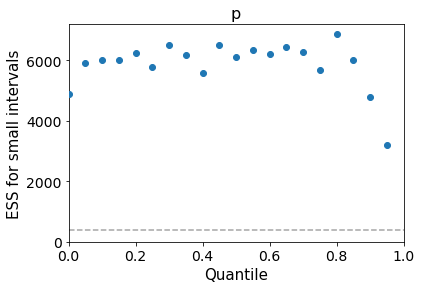

In [9]:
az.plot_ess(fit)

## trial을 늘린다면 어떻게 변화하는지 확인

In [33]:
# 100개의 리스트 중에서 0을 30개 1을 70개 넣은 리스트를 만들고 랜덤하게 섞어줌

hundred_list = [0] * 30 + [1] * 70
random.shuffle(hundred_list)

# 그 리스트를 넣어주기
temp_data1 = {
    'N' : 100,
    'y' : hundred_list
}
    

In [34]:
posterior = stan.build(bn_code, data=temp_data1, random_seed = 123)
fit = posterior.sample(num_chains = 4, num_samples=2000, num_warmup=1000)
trial2 = fit.to_frame()
trial2

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.000101 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.01 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!


parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,p
draws,,,,,,,,
0,-63.282141,1.000000,1.047772,1.0,1.0,0.0,63.652373,0.745776
1,-62.891783,0.946628,1.245847,1.0,1.0,0.0,62.903466,0.727508
2,-62.864773,0.855005,0.849553,1.0,3.0,0.0,64.687575,0.725788
3,-63.216846,0.832791,1.163666,2.0,3.0,0.0,63.690235,0.743262
4,-63.934620,0.834016,1.047772,1.0,1.0,0.0,64.021999,0.765558
...,...,...,...,...,...,...,...,...
7995,-63.729850,0.745505,1.163666,1.0,3.0,0.0,63.824873,0.626506
7996,-62.793353,0.841334,1.047772,2.0,3.0,0.0,63.596716,0.720622
7997,-62.751184,0.989727,1.245847,1.0,1.0,0.0,62.775896,0.674663


In [36]:
# 100번을 진행하면 사후 평균은 0.69
trial2['p'].describe()

count    8000.000000
mean        0.696200
std         0.045179
min         0.539858
25%         0.666168
50%         0.697557
75%         0.727084
max         0.847496
Name: p, dtype: float64

In [37]:
# 10번을 진행했을 때 사후 평균 0.67
trial1['p'].describe()

count    8000.000000
mean        0.667559
std         0.133379
min         0.183397
25%         0.575840
50%         0.678283
75%         0.768627
max         0.970558
Name: p, dtype: float64

In [52]:
# 보고싶은 4분위를 내가 조절해서 보면됨
trial2['p'].describe(percentiles=[.25, .4, .7, .9])

count    8000.000000
mean        0.696200
std         0.045179
min         0.539858
25%         0.666168
40%         0.685539
50%         0.697557
70%         0.720674
90%         0.753493
max         0.847496
Name: p, dtype: float64

array([[<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

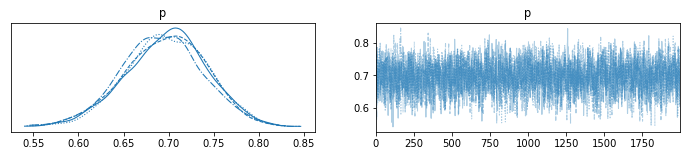

In [54]:
az.plot_trace(fit)

array([[<AxesSubplot:title={'center':'p'}>]], dtype=object)

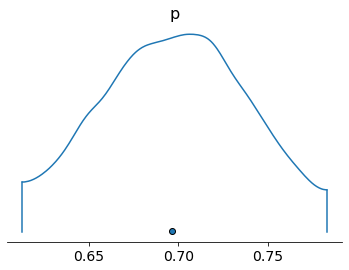

In [38]:
# 10번했을때보다 신뢰구간이 좁아진것이 확인됨.

az.plot_density(fit)

## 정규분포 튜토리얼 평균과 분산을 stan을 통해 베이지안 방법으로 추정

In [58]:
## 교통량 불러오기
df = pd.read_excel('2020통행속도.xlsx')
df

,일자,요일,도로명,링크아이디,시점명,종점명,방향,거리,차선수,기능유형구분,...,15시,16시,17시,18시,19시,20시,21시,22시,23시,24시
0,20200801,토,4.19로,1080012200,아카데미하우스,국립4.19묘지,상행,1179,1,보조간선도로,...,45.88,32.05,40.20,29.37,22.45,29.43,34.44,34.02,49.66,50.91
1,20200801,토,4.19로,1080012800,국립4.19묘지,국립4.19묘지입구,상행,352,2,보조간선도로,...,10.74,8.76,11.49,12.63,15.12,13.26,17.29,17.06,17.39,18.21
2,20200801,토,4.19로,1080012700,국립4.19묘지입구,국립4.19묘지,하행,354,2,보조간선도로,...,20.17,19.19,20.25,20.55,19.22,19.48,21.73,22.56,22.36,22.29
3,20200801,토,4.19로,1080012100,국립4.19묘지,아카데미하우스,하행,1190,1,보조간선도로,...,43.06,43.53,61.53,60.40,47.24,49.73,45.53,48.78,50.48,39.41
4,20200801,토,가락로,1230024700,방이초교,방이동고분군,상행,844,1,기타도로,...,15.34,15.47,16.98,16.12,15.24,16.40,16.54,15.62,18.48,16.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149046,20200831,월,휘경로,1050019700,외대앞역,이경시장삼거리,상행,364,2,기타도로,...,30.39,32.26,39.06,29.03,31.37,34.89,33.02,33.15,34.04,34.99
149047,20200831,월,휘경로,1050019800,이경시장삼거리,외대앞역,하행,364,2,기타도로,...,18.26,14.51,18.78,11.88,12.23,18.76,25.27,18.15,15.58,18.98
149048,20200831,월,휘경로,1050020200,외대앞역,외국어대,하행,434,1,기타도로,...,19.35,17.77,18.91,18.45,21.05,19.63,18.34,14.82,19.95,21.86
149049,20200831,월,희우정로,1130016400,망원정사거리,한강공원입구,상행,692,2,기타도로,...,21.90,19.64,20.62,21.29,17.94,17.85,18.71,21.20,20.21,22.01


In [65]:
gangnam = df[(df['도로명'] == '강남대로')].reset_index(drop=True)
gangnam = gangnam[['도로명', '18시']]
gangnam

,도로명,18시
0,강남대로,28.47
1,강남대로,26.41
2,강남대로,30.52
3,강남대로,37.70
4,강남대로,18.80
...,...,...
925,강남대로,33.05
926,강남대로,17.90
927,강남대로,18.80
928,강남대로,22.30


<AxesSubplot:xlabel='18시', ylabel='Count'>

/Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  func(*args, **kwargs)
/Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


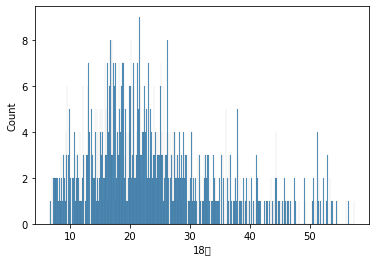

In [70]:
seaborn.histplot(gangnam['18시'], bins = 500)

## stan코드 작성

In [95]:
gangnam_code = """

data {
    int N; 
    real y[N];
}

parameters {
    real mu;
    real <lower = 0> sigma;
}

model {
    y ~ normal(mu, sigma);
}

generated quantities {
    real y_pred;
    y_pred = normal_rng(mu, sigma);
}

"""

### parameters에는 추정하는 값을 넣어줌,
### model에는 y가 정규분포의 mu와 시그마를 따른다. 시그마는 표준편차
### generated quantities는 예측분포를 생성하는것. y_pred라는 변수를 저장해주고 normal에 random number를 generate해라 이것은 데이터를 바탕으로 모수들을 가능도를 기반으로 추정함. 추정된 mu와 시그마를 바탕으로 새롭게 y의 분포를 구성하는게 generated quantities임.. 새롭게 노말 분포를 구성하게 만드는것

In [96]:
# stan 돌려보기
data1 = {
    'N' : len(gangnam),
    'y' : gangnam['18시'].tolist()
}

In [97]:
posterior1 = stan.build(gangnam_code, data=data1, random_seed = 123)
fit1 = posterior1.sample()

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s


clang-11: warning: -Wl,-export_dynamic: 'linker' input unused [-Wunused-command-line-argument]


Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s


In file included from /Users/tk/Library/Caches/httpstan/4.6.1/models/z7o6slqs/model_z7o6slqs.cpp:2:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:6:
/Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/prim/err/check_matching_dims.hpp:33:8: warning: unused variable 'error' [-Wunused-variable]
  bool error = false;
       ^
/Users/tk/opt/anaconda3/envs/p

Building: 2.4s
Building: 2.5s


In file included from /Users/tk/Library/Caches/httpstan/4.6.1/models/z7o6slqs/model_z7o6slqs.cpp:2:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/prim/err.hpp:50:
/Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/prim/err/hmm_check.hpp:33:7: wa

Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s


In file included from /Users/tk/Library/Caches/httpstan/4.6.1/models/z7o6slqs/model_z7o6slqs.cpp:2:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^
/Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:96:

Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s


In file included from /Users/tk/Library/Caches/httpstan/4.6.1/models/z7o6slqs/model_z7o6slqs.cpp:2:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:54:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/

Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s


In file included from /Users/tk/Library/Caches/httpstan/4.6.1/models/z7o6slqs/model_z7o6slqs.cpp:2:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:121:
/Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/matrix_power.hpp:52:24: warning: comparison of integers of different signs: 'size_t' (aka 'unsigned long') and 'const int' [-Wsign-compare]
  for (size_t i = 2; i <= n; ++i) {
                     ~ ^  ~
In file included from /Users/tk/Library/Caches/httpstan/4.6.1/models/z7o6slqs/model_z7o

Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s


In file included from /Users/tk/Library/Caches/httpstan/4.6.1/models/z7o6slqs/model_z7o6slqs.cpp:2:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:11:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/functor.hpp:28:
/Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/functor/operands_and_partials.hpp:29:1: warning: 'ops_partials_edge' defined as a class template here but previously declared as a struct template; this is valid, but may result in linker errors under the Microsoft C++ ABI [-Wmismatched-tags]
class ops_partials_edge<double, var> {
^
/Users/t

Building: 6.1s
Building: 6.2s


In file included from /Users/tk/Library/Caches/httpstan/4.6.1/models/z7o6slqs/model_z7o6slqs.cpp:2:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob.hpp:87:
/Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob/double_exponential_cdf.hpp:77:10: warning: unused variable 'N' [-Wunused-variable]
  size_t N = max_size(y, mu, sigma);
         ^
In file included from /Users/tk

Building: 6.3s
Building: 6.4s


In file included from /Users/tk/Library/Caches/httpstan/4.6.1/models/z7o6slqs/model_z7o6slqs.cpp:2:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob.hpp:139:
/Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob/hmm_marginal.hpp:26:13: warning: unused variable 'n_states' [-Wunused-variable]
  const int n_states = omegas.rows();
            ^


Building: 6.5s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s


In file included from /Users/tk/Library/Caches/httpstan/4.6.1/models/z7o6slqs/model_z7o6slqs.cpp:2:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob.hpp:307:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/prim/pro

Building: 7.1s
Building: 7.2s


In file included from /Users/tk/Library/Caches/httpstan/4.6.1/models/z7o6slqs/model_z7o6slqs.cpp:2:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:17:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/model/indexing.hpp:6:
/Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/model/indexing/assign.hpp:270:21: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<int, std::__1::allocator<int>>::size_type' (aka 'unsigned long') [-Wsign-compare]
  for (int i = 0; i < idx.ns_.size(); ++i) {
                  ~ ^ ~~~~~~~~~~~~~~
/Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/model/indexing/assign.hpp:538:21: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<int, std::__1::allocator<int>>::size_type' (aka 'unsigned long') [-Wsig

Building: 7.3s


In file included from /Users/tk/Library/Caches/httpstan/4.6.1/models/z7o6slqs/model_z7o6slqs.cpp:2:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core.hpp:29:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core/operator_divide_equal.hpp:5:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core/operator_division.hpp:14:
/Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/r

Building: 7.4s
Building: 7.5s
Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s


In file included from /Users/tk/Library/Caches/httpstan/4.6.1/models/z7o6slqs/model_z7o6slqs.cpp:2:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
/Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:80:21: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
      [avi = a.vi_, b](const auto& vi) mutable { avi->adj_ += vi.adj_; });
                    ^
/Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/

Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.6s
Building: 8.7s


In file included from /Users/tk/Library/Caches/httpstan/4.6.1/models/z7o6slqs/model_z7o6slqs.cpp:2:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/prim/err.hpp:4:
In file included from /Users/tk/opt/anaconda3/envs/pystan/lib/python3.8/site-packages/httpstan/include/stan/math/prim/err/c

Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s


55 warnings generated.
ld: warning: -pie being ignored. It is only used when linking a main executable


Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.6s


Building: 11.6s, done.
Messages from stanc:
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.001074 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.74 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00105 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001042 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.42 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001053 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.53 seconds.
  Adjust your expectations accordingly!


In [99]:
data2 = fit1.to_frame()
data2

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,y_pred
draws,,,,,,,,,,
0,-2664.731434,0.969447,0.905397,1.0,1.0,0.0,2664.765681,23.941398,10.440233,40.732890
1,-2664.379515,0.903492,0.870065,3.0,7.0,0.0,2665.526393,23.817374,10.735526,27.982710
2,-2668.724090,1.000000,1.066009,2.0,3.0,0.0,2670.014517,23.998293,9.976196,8.154440
3,-2664.342915,0.961016,0.993616,2.0,3.0,0.0,2667.024406,23.972594,10.577380,22.149568
4,-2664.540379,0.905230,0.905397,2.0,7.0,0.0,2665.492695,23.747039,10.780450,30.491210
...,...,...,...,...,...,...,...,...,...,...
3995,-2664.722902,0.941356,0.993616,2.0,3.0,0.0,2664.919131,24.298459,10.674775,29.795204
3996,-2664.278179,0.985732,0.905397,1.0,3.0,0.0,2664.591029,23.931819,10.710240,11.532920
3997,-2665.414206,0.882489,0.870065,2.0,3.0,0.0,2665.596980,23.519989,10.894633,30.347082


In [101]:
data2['y_pred'].describe()

count    4000.000000
mean       24.185227
std        11.019863
min       -13.062088
25%        16.980346
50%        24.317287
75%        31.458106
max        59.414279
Name: y_pred, dtype: float64

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'y_pred'}>,
        <AxesSubplot:title={'center':'y_pred'}>]], dtype=object)

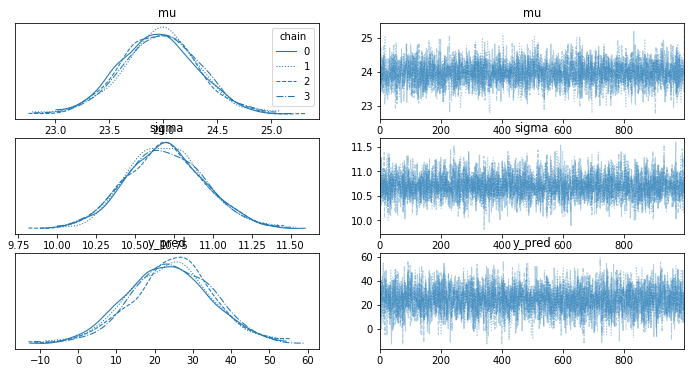

In [104]:
az.plot_trace(fit1, legend=True)

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'y_pred'}>]], dtype=object)

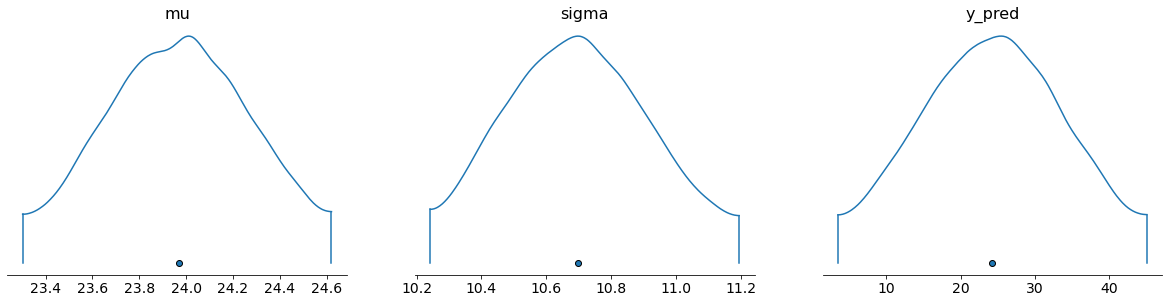

In [105]:
# 10번했을때보다 신뢰구간이 좁아진것이 확인됨.

az.plot_density(fit1)

<AxesSubplot:>

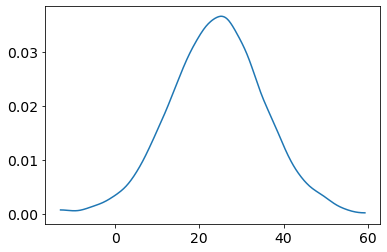

In [106]:
az.plot_dist(fit1['y_pred'])

<AxesSubplot:>

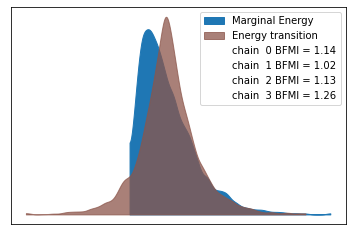

In [109]:
az.plot_energy(fit1)